# **Adding library**

In [ ]:
#adding library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import random for random between a and b (not include a, b)
import random

# **Pull data directly and unzip from grouplens website**

In [ ]:
DATASET_LINK='http://files.grouplens.org/datasets/movielens/ml-100k.zip'
!wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -n ml-100k.zip

File ‘ml-100k.zip’ already there; not retrieving.

Archive:  ml-100k.zip


# **Describe data, statistics data in general way**

## *Describe*

In [ ]:
# Viewing u.data file
column_names1 = ['user id','movie id','rating','timestamp']
df = pd.read_csv('ml-100k/u.data', sep='\t',header=None,names=column_names1)
df.head()

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
#check min, max rating and count how many the distincts value
print("rating:")
print(df.rating.max())
print(df.rating.min())
print(df.rating.value_counts())

#check how many the distincts value of users id
print("user:")
print(df["user id"].value_counts())
#check how many the distincts value of video
print("video:")
print(df["movie id"].value_counts())

rating:
5
1
4    34174
3    27145
5    21201
2    11370
1     6110
Name: rating, dtype: int64
user:
405    737
655    685
13     636
450    540
276    518
      ... 
441     20
36      20
812     20
895     20
93      20
Name: user id, Length: 943, dtype: int64
video:
50      583
258     509
100     508
181     507
294     485
       ... 
852       1
1505      1
1653      1
1452      1
1641      1
Name: movie id, Length: 1682, dtype: int64


In [ ]:
df['rating'].describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

## *Statistics and charts*

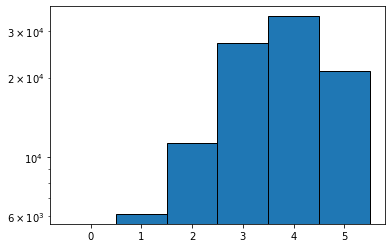

In [ ]:
plt.hist(df['rating'], bins=np.arange(7)-0.5, ec="k",log=True);
plt.plot();
plt.show();

# **Offline phase**



## *Build matrix factorization using svd++*


In [ ]:
#@title Default title text
class SVDpp:
# Khởi tạo các biến cho class SVDpp
# matrixDataSet là tập dữ liệu đưa vào (tập train), numFactor là số factor ẩn
# bi là bias của item i, bu là bias của item u
# qi là dictionary chứa những key (id item) và giá trị của key là ma trận (1 cột) 
#   numFactor số random trong nữa khoảng [0,1)
# qu là dictionary chứa những key (id user) và giá trị của key là ma trận (1 cột)
#   numFactor số random trong nữa khoảng [0,1)
# yi là dictionary chứa những key (id item) và giá trị của key là ma trận (1 cột)
#   numFactor số 0.1; đây là ma trận những nhân tố ẩn.
# avg là trung bình rating của matrixDataSet đưa vào.
# u_dict là dictionary chứa các key là user id và value là danh sách các item id
#   mà user đó đã rate.
    def __init__(self, matrixDataSet, numFactor=20):
        self.matrixDataSet = np.array(matrixDataSet)
        self.numFactor = numFactor
        self.bi = {}
        self.bu = {}
        self.qi = {}
        self.pu = {}
        self.avg = np.mean(self.matrixDataSet[:, 2])
        self.yi = {}
        self.u_dict = {}
        for i in range(self.matrixDataSet.shape[0]):
            user_id = self.matrixDataSet[i, 0]
            item_id = self.matrixDataSet[i, 1]
            self.u_dict.setdefault(user_id, [])
            self.u_dict[user_id].append(item_id)
            self.bi.setdefault(item_id, 0)
            self.bu.setdefault(user_id, 0)
            self.qi.setdefault(item_id, np.random.random((self.numFactor, 1)))
            self.pu.setdefault(user_id, np.random.random((self.numFactor, 1)))
            self.yi.setdefault(item_id, np.zeros((self.numFactor, 1)) + .1)

# Tính căn bậc 2 của Nu và Σyj. It used for predict, train method
# Nu is the amount of item which user rated. Get from u_dict
# userImplicitFactor is the result of sqrt(Nu) multiply Σyj
    def getNuYj(self, user_id, item_id):
            Nu = self.u_dict[user_id]
            numItemOfNu = len(Nu)
            sqrt_Nu = np.sqrt(numItemOfNu)
            y_u = np.zeros((self.numFactor, 1))
            if numItemOfNu == 0:
                userImplicitFactor = y_u
            else:
                for idItem in Nu:
                    y_u += self.yi[idItem]
                userImplicitFactor = y_u / sqrt_Nu

            return userImplicitFactor, sqrt_Nu

# Hàm predict để predict rating
# Phương thức setdefault là dành cho những item, user mới vào hệ thống
#   và thiết lập bi, bu, qi, pu và yi bằng 0. Khởi tạo mảng item rỗng mà user id
#   đã rate (chưa có gì)
# Bởi vì score nằm trong đoạn từ 1 đến 5, khi điểm lớn hơn 5 trả về 5 
# hoặc nhỏ hơn 1, 1 sẽ được trả về.
    def predict(self, user_id, item_id):  
        self.bi.setdefault(item_id, 0)
        self.bu.setdefault(user_id, 0)
        self.qi.setdefault(item_id, np.zeros((self.numFactor, 1)))
        self.pu.setdefault(user_id, np.zeros((self.numFactor, 1)))
        self.yi.setdefault(item_id, np.zeros((self.numFactor, 1)))
        self.u_dict.setdefault(user_id, [])
        userImplicitFactor, sqrt_Nu = self.getNuYj(user_id, item_id)
        rating = self.avg + self.bi[item_id] + self.bu[user_id] + np.sum(
            self.qi[item_id] * (self.pu[user_id] + userImplicitFactor))
        if rating > 5:
            rating = 5
        if rating < 1:
            rating = 1
        return rating

# Train function which is build by the matrix factorization and the svd++
# Lambda thay cho lambda vì bị lỗi do trùng với anonymous function (lambda).
# At the step 2 of docx, we get all pair of user, item, but here, we use number
#   of the rating in dataset source and random to take by np.random.permutation()
#   method which references n number and return an contigent array of the n number from 0 to n-1
# Get all of rating in dataset: self.matrixDataSet.shape[0]
    def train(self, epochs=20, alpha=0.005, Lambda=0.02):
        for epoch in range(epochs):
            print('epoch', epoch + 1, 'is running')
            Yui = np.random.permutation(self.matrixDataSet.shape[0])
            # Stochastic Gradient Descent
            rmse = 0.0
            for i in range(self.matrixDataSet.shape[0]):
                j = Yui[i]
                user_id = self.matrixDataSet[j, 0]
                item_id = self.matrixDataSet[j, 1]
                rating = self.matrixDataSet[j, 2]
                predict = self.predict(user_id, item_id)
                userImplicitFactor, sqrt_Nu = self.getNuYj(user_id, item_id)
                eui = rating - predict #step 7
                rmse += eui ** 2
                tempPu = self.pu[user_id] - alpha * (Lambda * self.pu[user_id] - eui * self.qi[item_id])
                tempQi = self.qi[item_id] - alpha * (Lambda * self.qi[item_id] - eui * (self.pu[user_id] + userImplicitFactor))
                self.bu[user_id] -= alpha * (Lambda * self.bu[user_id] - eui) #step 10
                self.bi[item_id] -= alpha * (Lambda * self.bi[item_id] - eui)
                for j in self.u_dict[user_id]: #step 14
                    self.yi[j] -= alpha * (Lambda * self.yi[j] - eui * self.qi[j] / sqrt_Nu)
                self.pu[user_id] = tempPu
                self.qi[item_id] = tempQi
            print('rmse: ', np.sqrt(rmse / self.matrixDataSet.shape[0]))


    def test(self, test_data):
        test_data = np.array(test_data)
        print('test data size: ', test_data.shape)
        rmse = 0.0
        for i in range(test_data.shape[0]):
            user_id = test_data[i, 0]
            item_id = test_data[i, 1]
            rating = test_data[i, 2]
            eui = rating - self.predict(user_id, item_id)
            rmse += eui ** 2
        print('rmse of test data is: ', np.sqrt(rmse / test_data.shape[0]))
        return np.sqrt(rmse / test_data.shape[0])

## *Preparing data to train*

### - Random (or load if right) data to train and test

In [ ]:
column_names1 = ['user id','movie id','rating','timestamp']
datatrain = pd.read_csv('/content/ml-100k/u1.base', sep='\t',header=None,names=column_names1)
datatest = pd.read_csv('/content/ml-100k/u1.test', sep='\t',header=None,names=column_names1)

### - Check, filter data

In [ ]:
## Lấy dữ liệu và lọc dữ liệu (xóa duplicate, null, NaN)
datatrain.dropna(inplace=True)
datatrain.drop_duplicates(inplace=True)
datatest.dropna(inplace=True)
datatest.drop_duplicates(inplace=True)


## Lấy dữ liệu gồm title, id phim từ u.item và lọc
col = 'movie id | movie title | release date | video release date | IMDb URL | unknown | Action '
col+= '| Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir '
col+= '| Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'
colItem = col.split(' | ')
movieItem = pd.read_csv('ml-100k/u.item', 
                        sep='|',header=None,names=colItem,encoding='latin-1')
movieItem = movieItem[['movie id','movie title']]
movieItem.dropna(inplace=True)
movieItem.drop_duplicates(inplace=True)

## *Training*

### 1. Predict before train (testing)

In [ ]:
numFactor = 20
beforetrain = SVDpp(datatrain, numFactor)

In [ ]:
#196	242	3	881250949
#186	302	3	891717742
#22	377	1	878887116
print (beforetrain.predict(196, 242))
print (beforetrain.predict(186	,302))
print (beforetrain.predict(22,	377))

5
5
5


### 2. To train
epochs=20, numFactor=10,
times~=40'

In [ ]:
numFactor = 10
model = SVDpp(datatrain, numFactor)
model.train(epochs=5)

epoch 1 is running
rmse:  1.1418633334993153
epoch 2 is running
rmse:  1.0078133215799512
epoch 3 is running
rmse:  0.975830914253232
epoch 4 is running
rmse:  0.9569562249880843
epoch 5 is running
rmse:  0.9437353513493676


### 3. After trained (testing)

In [ ]:
print (datatest.shape[0])
test_data = np.array(datatest)
print('test data size', datatest.shape[0])
table={}
table[numFactor] = [model.test(datatest)]
# Create DataFrame
df = pd.DataFrame(table)

# Print the output.
print(df)

20000
test data size 20000
test data size:  (20000, 4)
rmse of test data is:  1.0033410661590405
         10
0  1.003341


In [ ]:
# predict rating
#196	242	3
#186	302	3
#22	377	1
print (model.predict(196, 242))
print (model.predict(186	,302))
print (model.predict(22,	377))

#1	6	5	887431973
#1	10	3	875693118
print("===================")
print (model.predict(1	,6))
print (model.predict(1,	10))

#247	50	5	893097024
#328	470	4	885046537
print("===================")
print (model.predict(247	,50))
print (model.predict(328,	470))

4.261731867950952
3.6691783734742396
2.730751065208784
4.1063066705884195
4.107204435499964
4.355582033975845
3.7932378729185645


Cho thấy việc predict ngày càng chính xác hơn nếu chúng ta build với epoch, numfactor cao hơn (không quá cao). Epoch cỡ 100-200, numFactor cỡ 20!?

## *Train more*

### *Train thay đổi epochs, numFactor trên 1 tập dữ liệu train u1.base*

epochs=50, numFactor=20 => times ~= 1h30

In [ ]:
modelFifTwe = SVDpp(datatrain, numFactor=20)
modelFifTwe.train(epochs=50)

epoch 1 is running
rmse:  1.2127756322517043
epoch 2 is running
rmse:  1.0403626458905162
epoch 3 is running
rmse:  0.9966144720109955
epoch 4 is running
rmse:  0.9689930278485509
epoch 5 is running
rmse:  0.9493579319364884
epoch 6 is running
rmse:  0.9340799476830878
epoch 7 is running
rmse:  0.9213990170670386
epoch 8 is running
rmse:  0.9102606720777253
epoch 9 is running
rmse:  0.9003509134253267
epoch 10 is running
rmse:  0.8918298720004196
epoch 11 is running
rmse:  0.8835142120594934
epoch 12 is running
rmse:  0.8753327946592122
epoch 13 is running
rmse:  0.8678003686575411
epoch 14 is running
rmse:  0.8602283844580954
epoch 15 is running
rmse:  0.8529303925159406
epoch 16 is running
rmse:  0.8453384530210101
epoch 17 is running
rmse:  0.8385642309939273
epoch 18 is running
rmse:  0.8307618013909703
epoch 19 is running
rmse:  0.8239128102961274
epoch 20 is running
rmse:  0.8166723778914584
epoch 21 is running
rmse:  0.8091798190573646
epoch 22 is running
rmse:  0.80244964197962

In [ ]:
# predict rating
#196	242	3
#186	302	3
#22	377	1
print (modelFifTwe.predict(196, 242))
print (modelFifTwe.predict(186	,302))
print (modelFifTwe.predict(22,	377))

#1	6	5	
#1	10	3	
print("===================")
print (modelFifTwe.predict(1	,6))
print (modelFifTwe.predict(1,	10))

#247	50	5	
#328	470	4	
print("===================")
print (modelFifTwe.predict(247	,50))
print (modelFifTwe.predict(328,	470))

3.8358237744887047
2.9166611662620197
2.6927850006931315
3.607549634044278
3.062126955587438
4.400828893820662
3.8912683263094645


epochs=100 numFactor=20

In [ ]:
modelHundFif = SVDpp(datatrain, numFactor=20)
modelHundFif.train(epochs=100)

epoch 1 is running
rmse:  1.2098767865103766
epoch 2 is running
rmse:  1.0367281571458218
epoch 3 is running
rmse:  0.9933641436948908
epoch 4 is running
rmse:  0.966272277918801
epoch 5 is running
rmse:  0.9468591932015173
epoch 6 is running
rmse:  0.9315970173059981
epoch 7 is running
rmse:  0.9195135965814174
epoch 8 is running
rmse:  0.9080633188939393
epoch 9 is running
rmse:  0.8985438584164058
epoch 10 is running
rmse:  0.889806933962878
epoch 11 is running
rmse:  0.8810481209947766
epoch 12 is running
rmse:  0.8730353331801601
epoch 13 is running
rmse:  0.8650391225096681
epoch 14 is running
rmse:  0.8574074469429468
epoch 15 is running
rmse:  0.8497473224204901
epoch 16 is running
rmse:  0.84235440392463
epoch 17 is running
rmse:  0.8347225271701153
epoch 18 is running
rmse:  0.8274305428979001
epoch 19 is running
rmse:  0.8199427241921706
epoch 20 is running
rmse:  0.8128495620162429
epoch 21 is running
rmse:  0.8055256601842096
epoch 22 is running
rmse:  0.798356097030288
ep

KeyboardInterrupt: ignored

In [ ]:
# predict rating
#196	242	3
#186	302	3
#22	377	1
print (modelHundFif.predict(196, 242))
print (modelHundFif.predict(186	,302))
print (modelHundFif.predict(22,	377))

#1	6	5	
#1	10	3	
print("===================")
print (modelHundFif.predict(1	,6))
print (modelHundFif.predict(1,	10))

#247	50	5	
#328	470	4	
print("===================")
print (modelHundFif.predict(247	,50))
print (modelHundFif.predict(328,	470))

3.6272367747277787
3.3581318071006887
1.7370827321949707
2.6245754557217977
3.9029981473726507
4.334241515462834
3.0536613892789966


*Cho thấy build với epochs lớn, và factor lớn thì độ chính xác càng lớn. Nhưng trái lại thời gian build rất lâu; 85 epoch, 20 factor ~= 3h*

### A testing chains

In [ ]:
modelTwTwChains = SVDpp(datatrain, numFactor=20)
modelTwTwChains.train(epochs=10)
modelTwTwChains.train(epochs=20)
modelTwTwChains.train(epochs=20)

In [ ]:
# predict rating
#196	242	3
#186	302	3
#22	377	1
print (modelTwTwChains.predict(196, 242))
print (modelTwTwChains.predict(186	,302))
print (modelTwTwChains.predict(22,	377))

#1	6	5	
#1	10	3	
print("===================")
print (modelTwTwChains.predict(1	,6))
print (modelTwTwChains.predict(1,	10))

#247	50	5	
#328	470	4	
print("===================")
print (modelTwTwChains.predict(247	,50))
print (modelTwTwChains.predict(328,	470))

# Online phase - Recommend films

In [ ]:
#model = SDVpp(), above
userid=1
amountMovie=3

def checkItemRated(itemid, userid, model):
  listItem = model.u_dict[userid]
  for item in listItem:
    if item == itemid:
      return True
  return False

def recommendFilm(model, userid, amountMovieSystem=1682, amountMovie=3):
  i=1
  countItemRated=0
  bestMovies = {}
  while i <= amountMovieSystem:
    if checkItemRated(i, userid, model):
      #print("item is rated: ", i)
      i+=1
      countItemRated+=1
      continue
    bestMovies[i]=model.predict(userid, i)
    #print("item is not rated", i, " with predict", bestMovies[i])
    i += 1
  sortedBestMovies = sorted(bestMovies.items(), key=lambda x: x[1], reverse=True)
  print("=======================================")
  print("bias:", model.bu[userid])
  print("number of rated:", countItemRated)
  return sortedBestMovies[0:amountMovie]


In [ ]:
print("model", recommendFilm(model, 1))
print("modelFifTwe",recommendFilm(modelFifTwe, 1))
#print("modelTwTwChains",recommendFilm(modelTwTwChains, 1))
print("modelHundFif",recommendFilm(modelHundFif, 1))

bias: 0.023871366793141384
number of rated: 135
model [(12, 4.7880036310767125), (483, 4.755237093815905), (318, 4.727831206760823)]
bias: 0.23620157297312752
number of rated: 135
modelFifTwe [(56, 5), (64, 5), (92, 5)]
bias: 0.029071557066634456
number of rated: 135
modelHundFif [(64, 5), (98, 5), (100, 5)]
